# Processing Sequences Using RNNs and CNNs

In this chapter we will discuss recurrent neural networks (RNNs), a class of nets that can predict the future (well, up to a point, of course). They can analyze time series data such as stock prices and tell you when to buy or sell. In autonomous driving systems, they can anticipate car trajectories and help avoid accidents. More generally, they can work on sequences of arbitrary lengths, rather than on fixed-sized inputs like all the nets we have considered so far. For example, they can take sentences, documents, or audio samples as input, making them extremely useful for natural language processing applications such as automatic translation or speech-to-text.

The two main difficulties that RNNs face are:
1. Unstable gradients, which can be alleviated using various techniques, including recurrent dropout and recurrent layer normalization
2. A (very) limited short-term memory, which can be extended using LSTM or GRU cells

RNNs are not the only types of neural networks capable of handling sequential data: for small sequences, such as audio samples or text, convolutional neural networks can actually work quite well too.

## Recurrent Neurons and Layers

Up to now we have focused on feedforward neural networks, where the activations flow only in one direction, from the input layer to the output layer. A recurrent neural network looks very much like a feedforward network, except it also has connections pointing backward. You can easily create a layer of recurrent neurons. At each time step $t$, every neuron receives both the input vector $x_{(t)}$ and the output vector from the previous time step $y_{(t-1)}$. Each recurrent neuron has two sets of weights: one for the inputs $x_{(t)}$ and the other for the outputs of the previous time step $y_{(t-1)}$. 

Note that many researchers prefer to use the hyperbolic tangent (tanh) activation function in RNNs rather than the ReLU activation function. 

## Memory Cells

Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, you could say it has a form of *memory*. A part of a neural network that preserves some state across time steps is called a *memory cell*.

## Input and Output Sequences

An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs. This type of **sequence-to-sequence network** is useful for predicting time series such as stock prices. A **sequence-to-vector network** is useful for tasks like feeding the network a sequence of words corresponding to a movie review and the network would output a sentiment score from -1 to 1. Conversely, you can feed the network some input vector over and over again at each time step and let it ouptut a sequence. This is a **vector-to-sequence network**. For example, the input could be an image and the output could be caption for that image. Lastly, you could have a **sequence-to-vector network** called an **encoder** *followed by* a **vector-to-sequence network**, called a **decoder**, which is useful for tasks like translating a sentence from one language to another. 

## Training RNNs

To train an RNN, the trick is to unroll it through time and then simply use regular backpropagation. This strategy is called *backpropagation through time (BPTT)*. 

Just like in regular backpropagation, there is a first forward pass through the unrolled network then the output sequence is evaluated using a cost function. Note that this cost function may ignore some outputs (for example, in a sequence-to-vector RNN, all outputs are ignored except the very last one). The gradients of that cost function are then propagated backward through the unrolled network. Finally the model parameters are updated using the gradients computed during BPTT. Note that the gradients flow backward through all the outputs used by the cost function, not just through the final output.

## Forecasting a Time Series

Suppose you are studying the number of active users per hour on your website, or the daily temperature in your city, or your company's financial health, measured quarterly using multiple metrics. In all these cases, the data will be a sequence of one or more values per time step. This is called a *time series*. In the first two examples there is a single value per time step, so these are *univariate time series*, while in the financial exmaple there are multiple values per time step, so it is a *multivariate time series*. A typical tasks is to predict future values, which is called *forecasting*. Another common task is to fill in the blanks: to predict (or rather 'postdict') missing values from the past. This is called *imputation*.

In [1]:
import numpy as np

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

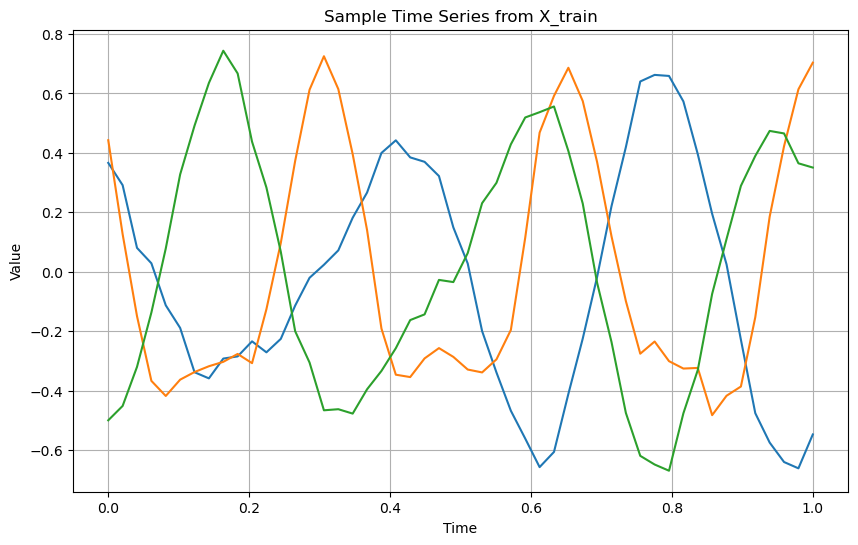

In [2]:
import matplotlib.pyplot as plt

# Select a few samples to plot (e.g., first 3)
n_samples_to_plot = 3
time = np.linspace(0, 1, n_steps)  # Time axis for X_train

plt.figure(figsize=(10, 6))
for i in range(n_samples_to_plot):
    plt.plot(time, X_train[i, :, 0], label=f'Series {i+1}')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Sample Time Series from X_train')
plt.grid(True)
plt.show()

**When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape [batch_size, time_steps, dimensionality], where dimensionality is 1 for univariate time series and more than 1 for multivariate time series**

## Baseline Metrics

Before we start using RNNs, it is often a good idea to have a few baseline metrics, or else we may end up thinking our model works great when in fact it is doing worse than basic models. For example, the simplest approach is to predict the last value in each series. This is called *naive forecasting*, and it is sometimes surprisingly difficult to outperform.

In [3]:
import tensorflow as tf

y_pred = X_valid[:, -1]
np.mean(tf.keras.losses.mean_squared_error(y_valid, y_pred))

0.020174038

Another simple approach is to use a fully connected network. Since it expects a flat list of features for each input, we need to add a Flatten layer.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Input, Dense

model = Sequential([
    Input([50, 1]),
    Flatten(),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20)
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 1s 969us/step - loss: 0.0967
Epoch 2/20
219/219 [==============================] - 0s 967us/step - loss: 0.0252
Epoch 3/20
219/219 [==============================] - 0s 986us/step - loss: 0.0149
Epoch 4/20
219/219 [==============================] - 0s 957us/step - loss: 0.0110
Epoch 5/20
219/219 [==============================] - 0s 920us/step - loss: 0.0091
Epoch 6/20
219/219 [==============================] - 0s 984us/step - loss: 0.0079
Epoch 7/20
219/219 [==============================] - 0s 909us/step - loss: 0.0071
Epoch 8/20
219/219 [==============================] - 0s 910us/step - loss: 0.0064
Epoch 9/20
219/219 [==============================] - 0s 954us/step - loss: 0.0059
Epoch 10/20
219/219 [==============================] - 0s 902us/step - loss: 0.0055
Epoch 11/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 12/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0048
Epoch

0.0036286180838942528

## Implementing a Simple RNN

In [5]:
from tensorflow.keras.layers import SimpleRNN

model = Sequential([
    Input(shape=[None, 1]),
    SimpleRNN(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20)
model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.0632
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0433
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0292
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0197
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0146
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0124
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0116
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0114
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0113
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0113
Epoch 11/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0112
Epoch 12/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0112
Epoch 13/20
219/219 [====

0.010764065198600292

We do not need to specify the length of the input sequences (unlike in the previous model), since a recurrent neural network can process any number of time steps (this is why we set the first input dimension to None). By default, the SimpleRNN layer uses the hyperbolic tangent activation function. It works exactly as we saw earlier: the initial state $h_{init}$ is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step $x_{0}$. The neuron computes a weighted sum of these values and applies the hyperbolic tangent functionto the result, and this gives the first output, $y_{0}$. In a simple RNN, this output is also the new state $h_{0}$. This new state is passed to the same recurrent neuron along wit hthe next input value $x_{1}$, and the process is repeated until the last time step. Then the layer just outputs the last value, $y_{49}$. All of this is performed simultaneously for every time series.

By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set return_sequences=True.

Note that for each neuron, a linear model has one parameter per input and per time step, plus a bias term (in the simple linear model we used, that's a total of 51 parameters). In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a simple RNN, that's just the numer of recurrent neurons in the layer), plust a bias term. In this simple RNN, that's a total of just three parameters.

## Trend and Seasonality

There are many other models to forecast time series, such as *weighted moving average* models or *autoregressive integrated moving average (ARIMA)* models. **Some of them require you to first remove the trend and seasonality**. For example, if you are studying the number of active users on your website, and it is growing by 10% every month, you would have to remove this trend from the time series. One the model is trained and starts making predictions, you would have toa dd the trend back to get the final predictions. Similarly, if you are trying to predict the amount of sunscreen lotion sold every month, you will probably observe strong seasonality: since it sells well every summer, a similar patter will be repeated every year. You would have to remove this seasonality from the time series, for example by computing the difference between the value at each time step and teh value one year earlier (this technique is called *differencing*). Again, after the model is trained and makes predictions, you would have to add the seasonal pattern back to get the final predictions.

**When using RNNs, it is generally not necessary to do all this, but it may improve performance in some cases, since the model will not have to learn the trend or the seasonality**

## Deep RNNs

It is quite common to stack multiple layers of cells. This gives you a *deep RNN*. Implementing a deep RNN with tf.keras is quite simple: just stack recurrent layers.

In [6]:
model = Sequential([
    Input(shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=256)

Epoch 1/20
28/28 [==============================] - 4s 26ms/step - loss: 0.0531
Epoch 2/20
28/28 [==============================] - 1s 27ms/step - loss: 0.0131
Epoch 3/20
28/28 [==============================] - 1s 26ms/step - loss: 0.0071
Epoch 4/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0053
Epoch 5/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0044
Epoch 6/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0039
Epoch 7/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0036
Epoch 8/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0034
Epoch 9/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0033
Epoch 10/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0032
Epoch 11/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0032
Epoch 12/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0031
Epoch 13/20
28/28 [==================

Make sure to set return_sequences=True for all recurrent layers (except the last one, if you only care about the last output). If you don't they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

Note that the last layer is not ideal: it must have a single unit because we want to forecast a univariate time series, and this means we must have a single output value per time step. However, having a single unit means that the hidden state is just a single number. That's really not much, and it's probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer's hidden state very much. Moreover, since a SimpleRNN layer uses the tanh activation function by default, the predicted values must lie within the range -1 to 1. But what if you want to use another activation function? For both these reasons, it might be prferable to replace the output layer with a Dense layer: it would run slightly faster, the accuracy would be roughly the same, and it would allow us to choose any output activation function we want. If you make this change, also make sure to remove return_sequences=True from the second (now last) recurrent layer.

In [7]:
model = Sequential([
    Input(shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
219/219 [==============================] - 5s 14ms/step - loss: 0.0123
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0038
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0034
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0032
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0032
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0032
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0029
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0029
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0029
Epoch 11/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0027
Epoch 12/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0028
Epoch 13/20
2

## Forecasting Several Time Steps Ahead

So far we have only predicted the value at the next time step, but we could just as easily have predicted the value several time steps ahead by changing the targets appropriately (e.g. to predict 10 steps ahead, just change the targets to be the value 10 steps ahead of 1 step ahead). But what if we want to predict the next 10 values?

The first option is to use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occured), and use the model again to predict the following value, and so on, as in the following code:

In [8]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
Y_pred

1/1 [==============================] - 0s 35ms/step


array([[[ 0.27896515],
        [ 0.44218415],
        [ 0.5693965 ],
        [ 0.6157587 ],
        [ 0.57190204],
        [ 0.43547478],
        [ 0.24454051],
        [ 0.03767182],
        [-0.14267007],
        [-0.27939317]]], dtype=float32)

As you might expect, the prediction for the next step will usually be more accurate than the predictions for later time steps, since the errors might accumulate. It is much more meaningful to compare this performance with naive predictions or with a simple linear model.

The second option is to train an RNN to predict all 10 next values at once. However, we first need to change the targets to be vectors containing the next 10 values, like so:

In [9]:
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

model = Sequential([
    Input(shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20),
    Dense(10)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=256)
Y_pred = model.predict(X_new)
Y_pred

Epoch 1/20
28/28 [==============================] - 2s 18ms/step - loss: 0.1797
Epoch 2/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0791
Epoch 3/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0535
Epoch 4/20
28/28 [==============================] - 1s 24ms/step - loss: 0.0447
Epoch 5/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0402
Epoch 6/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0369
Epoch 7/20
28/28 [==============================] - 1s 21ms/step - loss: 0.0343
Epoch 8/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0319
Epoch 9/20
28/28 [==============================] - 0s 18ms/step - loss: 0.0291
Epoch 10/20
28/28 [==============================] - 0s 17ms/step - loss: 0.0260
Epoch 11/20
28/28 [==============================] - 1s 18ms/step - loss: 0.0227
Epoch 12/20
28/28 [==============================] - 0s 18ms/step - loss: 0.0207
Epoch 13/20
28/28 [==================

array([[ 0.3071501 ,  0.4241963 ,  0.5587694 ,  0.61880934,  0.56253994,
         0.4569526 ,  0.2527987 ,  0.06278664, -0.20020795, -0.32083017]],
      dtype=float32)

But we can still do better: indeed, instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. **The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step. This means there will be many more error gradients flowing through the model, and they won't have to rflow only through time, they will also flow from the output of each time step. This will stabalize and speed up training**.

To be clear, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 10, then at time step 1 the model will forecast time steps 2 to 11, and so on. It may be surprising that the targets will contain values that appear in the inputs (there is a lot of overlap between X_train and Y_train). Isn't that cheating? Fortunately, not at all: at each time step, the model only knows about past time steps, so it cannot look ahead. It is said to be a *causal* model.

**To turn the model into a sequence-to-sequence model, we must set return_sequences=True in all recurrent layers (even the last one), and we must apply the output Dense layer at each time step. Keras offers a TimeDistributed layer for this very purpose: it wraps any layer and applies it at every time step of its input sequence.** It does this efficiently, by reshaping the inputs so that each time step is treated as a sequence instance (i.e. it reshapes the inputs from [batch_size, time_steps, input_dimensions] to [batch_size x time_steps, input_dimensions]); in this example, the number of input dimensions is 20 because the previous SimpleRNN layer has 20 units), then it runs the Dens layer, and finally it reshapes the output back to sequences.

In [10]:
from tensorflow.keras.layers import TimeDistributed

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

model = Sequential([
    Input(shape=[None, 1]),
    SimpleRNN(20, return_sequences=True),
    SimpleRNN(20, return_sequences=True),
    TimeDistributed(Dense(10))
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=20, batch_size=256)
Y_pred = model.predict(X_new)
Y_pred

Epoch 1/20
28/28 [==============================] - 3s 38ms/step - loss: 0.1820
Epoch 2/20
28/28 [==============================] - 1s 37ms/step - loss: 0.0844
Epoch 3/20
28/28 [==============================] - 1s 35ms/step - loss: 0.0670
Epoch 4/20
28/28 [==============================] - 1s 36ms/step - loss: 0.0603
Epoch 5/20
28/28 [==============================] - 1s 35ms/step - loss: 0.0564
Epoch 6/20
28/28 [==============================] - 1s 31ms/step - loss: 0.0536
Epoch 7/20
28/28 [==============================] - 1s 32ms/step - loss: 0.0516
Epoch 8/20
28/28 [==============================] - 1s 38ms/step - loss: 0.0499
Epoch 9/20
28/28 [==============================] - 1s 38ms/step - loss: 0.0485
Epoch 10/20
28/28 [==============================] - 1s 34ms/step - loss: 0.0472
Epoch 11/20
28/28 [==============================] - 1s 38ms/step - loss: 0.0459
Epoch 12/20
28/28 [==============================] - 1s 34ms/step - loss: 0.0447
Epoch 13/20
28/28 [==================

array([[[-5.83816528e-01, -8.29679728e-01, -6.95320964e-01,
         -5.11227608e-01, -4.77200121e-01, -1.60979897e-01,
          1.35582313e-01,  2.25186214e-01,  2.99913257e-01,
          4.48455781e-01],
        [-5.61971664e-01, -5.34493148e-01, -4.90867704e-01,
         -2.77382314e-01, -1.04087129e-01,  9.33538675e-02,
          2.60090500e-01,  3.87355059e-01,  5.88426471e-01,
          4.49228108e-01],
        [-3.09818536e-01, -2.80199833e-02,  2.08485514e-01,
          2.59474128e-01,  3.41916502e-01,  3.56340617e-01,
          3.52328151e-01,  4.21522826e-01,  3.28499466e-01,
          1.39280006e-01],
        [ 7.27178082e-02,  3.11407596e-01,  4.61060256e-01,
          4.50479567e-01,  4.64307725e-01,  4.45269376e-01,
          3.02100867e-01,  1.95767328e-01,  3.31510454e-02,
         -4.74651391e-03],
        [ 4.51696724e-01,  5.20865500e-01,  5.62156856e-01,
          5.72648406e-01,  3.69094223e-01,  2.64306009e-01,
          1.21670961e-01, -5.90399355e-02, -2.954176

The Dense layer actually supports sequences as inputs: it handles them just like TimeDistributed(Dense()), meaning it is applied to the last input dimension only (independently across all time steps). Thus, we could replace the last layer with just Dense(10). For the sake of clarity, however, we will keep using TimeDistributed(Dense(10)) because it makes it clear that the Dense layer is applied independently at each time step and that the model will output a sequence, not just a single vector.

All outputs are needed during training, but only the output at the last time step is useful for predictions and for evaluation. So although we will rely on the MSE over all outputs for training, we will use a custom metric for evaluation, to only compute the MSE over the output at the last time step:

In [11]:
def last_time_step_mse(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
model.fit(X_train, Y_train)

219/219 [==============================] - 6s 21ms/step - loss: 0.0366 - last_time_step_mse: 0.0220


You can combine this approach with the first one: just predict the next 10 values using this RNN, then concatenate these values to the input time series and use the model again to predict the next 10 values, and repeat the process as many times as you need. With this approach, you can generate arbitrarily long sequences. It may not be very accurate for long-term predictions, but it may be just fine if your goal is to generate original music or text. 

**When forecasting time series, it is often useful to have some error bars along with your predictions. For this, an efficient technique is MC Dropout, introducted in Chapter 11: add an MC Dropout layer within each memory cell, dropping part of the inputs and hidden states. After training, to forecast a new time series, use the model many times and compute the mean and standard deviation of the predictions at each time step**.

**Simple RNN's can be quite good at forecasting time series or handling other kinds of sequences, but they do not perform as well on long time series or sequences.**

## Handling Long Sequences

To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem, discussed in Chapter 11: it may take forever to train, or training may be unstable. Moreover, when an RNN processes a long sequence, it will gradually forget the first inputs in the sequence.

## Fighting the Unstable Gradients Problem

Many of the tricks we used in deep nets to alleviate the unstable gradients problem can also be used for RNNs: good parameter initialization, faster optimizers, dropout, and so on. **However, nonsaturating activation functions (e.g. ReLU) may not help as much here; in fact, they may actually lead the RNN to be even more unstable during training. Why? Well, suppose Gradient Descent updates the weights in a way that increases the outputs slightly at the first time step. Because the same weights are used at every time step, the outputs at the second time step may also be slightly increased, and those of the third, and so on until the outputs explode-- and a nonsaturating activation function does not prevent that.** 

You can reduce this risk by using a smaller learning, but you can also simply use a saturating activation function like the hyperbolic tangent (this explains why it is the default). **In much the same way, the gradients themselves can explode. If you notice that training is unstable, you may want to monitor the size of the gradients (e.g. using TensorBoard) and perhaps use Gradient Clipping.**

Moreover, Batch Normalization cannot be used as efficiently with RNNs as with deep feedforward nets. In fact, you cannot use it between time steps, only between recurrent layers. To be more precise, it is technically possible but in practice this does not yield good results. The authors of a 2015 paper found that BN was slightly beneficial only when it was applied to the inputs, not the hidden states. In other words, it was slightly better than nothing when applied between recurrent layers. In Keras this can be done simply by adding a BatchNormalization() layer before each recurrent layer, but don't expect too much from it.

Another form of normalization often works better the RNNs: *Layer Normalzation*. It is very similar to Batch Normalization, but instead of normalizing across the batch dimension, it normalizes across the feature dimension. One advantage is that it can compute the required statistics on the fly, at each time step, independently from each instance. This also means that it behaves the same way during training and testing (as opposed to BN), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set. Like BN, Layer Normalization learns a scale and and offset parameter for each input. In an RNN, it is typically used right after the linear combination of the inputs and hidden states. Let's use tf.keras to implement Layer Normalization. The following code implements a custom memory cell which will behave like a SimpleRNNCell, except it will also apply Layer Normalization at each time step:

In [12]:
from tensorflow.keras.layers import Layer, SimpleRNNCell, LayerNormalization

class LNSimpleRNNCell(Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = SimpleRNNCell(units, activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

The code is quite straightforward. Our LNSimpleRNNCell class inherits from the tf.keras.layers.Layer class, just like any customer layer. The constructor takes the number of units and the desired activation function, and it sets the state_size and output_size attributes, then creates a SimpleRNNCell with no activation function (because we want to perform Layer Normalization after the linear operation but before the activation function). Then the constructor creates the LayerNormalzation() layer, and finally it fetches the desired activation function. The call() method starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice. 

Next, the call() method applies Layer Normalization followed by the activation function. Finally, it returns the outputs twice. To use this custom cell, all we need to do is create a tf.keras.layers.RNN layer, passing it a cell instance:

In [13]:
from tensorflow.keras.layers import RNN

model = Sequential([
    RNN(LNSimpleRNNCell(20), return_sequences=True),
    RNN(LNSimpleRNNCell(20), return_sequences=True),
    TimeDistributed(Dense(10))
])

Similarly, you could create a custom cell to apply dropout between each time step. But there's a simpler way: all recurrent layers (except for tf.keras.layers.RNN) and all cells provided by Keras have a dropout hyperparameter and a recurrent_dropout hyperparameter:: the former defines the dropout rate to apply to the inputs (at each time step), and the latter defines the dropout rate for the hidden states (also at each time step).

With these techniques you can alleviate the unstable gradients problem and train an RNN much more efficiently. Now let's look at how to deal with the short-term memory problem.

## Tackling the Short-Term Memory Problem

Due to the transformations that the date goes through when traversing an RNN, some information is lost at each time step. After a while, the RNN's state contains virtually no trace of the first inputs. This can be a showstopper. To tackle this problem, various types of cells with long-term memory have been introduced. They have proven so successful that the basic cells are not used much anymore.

### LSTM cells

**The Long Short-Term Memory (LSTM)** cell was proposed in 1997. If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; training will converge faster, and it will detect long-term dependencies in the data. In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer:

In [14]:
from tensorflow.keras.layers import LSTM

model = Sequential([
    Input(shape=[None, 1]),
    LSTM(20, return_sequences=True),
    LSTM(20, return_sequences=True),
    TimeDistributed(Dense(10))
])

**So how does an LSTM work?** If you don't look at what's inside the box, the LSTM cell looks exactly like a regular cell, except that its state is split into two vectors: $h_{(t)}$ and $c_{(t)}$ (c stands for cell). You can think of $h_{(t)}$ as the short-term state and $c_{(t)}$ as the long-term state.

Now let's open the box! The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it. AS the long-term state $c_{(t-1)}$ traverses the network from left to right, you can see that it first goes through a *forget gate*, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an *input gate*). The result, $c_{(t)}$ is sent straight out, without any further transformation. So, at each time step, some memories are dropped and some memories are added. Moreover, after the addition operation, the long-term state is copied and passed through the tanh function, and then the result is filtered by the *output gate*. This produces the short-term state $h_{(t)}$ (which is equal to the cell's output for this time step, $y_{(t)}$). Now let's look at where new memories come from and how the gates work.

First, the current input vector $x_{(t)}$ and the previous shor-term state $h_{(t-1)}$ are fed to four different fully connected layers. They all serve a different purpose:
1. The main layer is the one that outputs $g_{(t)}$. It has the usual role of analyzing the current inputs $x_{(t)}$ and the previous (short-term) state $h_{(t-1)}$. In a basic cell, there is nothing other than this layer, and its output goes straight out to $y_{(t)}$ and $h_{(t)}$. In contrast, in an LSTM cell this layer's output does not go straight out, but instead its most important parts are stored in the long-term state (and the rest is dropped).
2. The three other layers are *gate controllers*. Since they use the logistic activation function, their outputs range from 0 to 1. As you can see, their outputs are fed to element-wise multiplication operations, so if they output 0s they close the gate, and if they output 1s they open it. Specifically:
   1. The *forget gate* (controlled by $f_{(t)}$) controls which parts of the long-term state should be erased.
   2. The *input gate* (controlled by $i_{(t)}$) controls which parts of $g_{(t)}$ should be added to the long-term state
   3. Finally, the *output gate* (controlled by $o_{(n)}$) controls which parts of the long-term state should be read and output at this time step, both to $h_{(t)}$ and $y_{(t)}$.

**In short, an LSTM cell can learn to recognize an important input (that's the role of the input gate), store it in the long-term state, preserve it for as long as it is needed (that's the role of the forget gate), and extract it whenver it is needed.**

### Peephole connections

In a regular LSTM cell, the gate controllers can look only at the input $x_{(t)}$ and the previous short-term state $h_{(t-1)}$. It may be a good idea to give them a bit more context by letting them peek at the long-term state as well. This idea was proposed in 2000. The authors proposed an LSTM variant with extra connections called *peephole connections*: the previous long-term state $c_{(t-1)}$ is added as an input to the controllers of the forget gate and the input gate, and the current long-term state $c_{(t)}$ is added as input to the controller of the output gate. **This often improves performance, but not always, and there is no clear pattern for which tasks are better off with or without them.**

The experimental tf.experimental.PeepholeLSTMCell, when passed into a keras.layers.RNN layer, produces this network. There are many other variants of the LSTM cell. One particularly popular variant is the GRU cell.

### GRU cells

The *Gated Recurrent Unit* (GRU) cell was proposed in a 2014 paper that also introduced the Encoder-Decoder network we discussed earlier. The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well. These are the main simplifications:
1. Both state vectors are merged into a single vector $h_{(t)}$.
2. A single gate controller $z_{(t)}$ controls both the forget gate and the input gate. If the gate controller outputs a 1, the forget gate is open (=1) and the input gate is closed (1-1=0). If the ouput is 0, the opposite happens. In other words, whenever a memory must be stored, the location where it will be stored is erased first. This is actually a fequent variant to the LSTM cell in and of itself.
3. There is no output gate the full state vector is output at every time step. However, there is a new gate controller $r_{(t)}$ that controls which part of the previous state will be shown to the main layer ($g_{(t)}$)

Keras provides a keras.layers.GRU layer: using it is just a matter of replacing SimpleRNN or LSTM with GRU. LSTM and GRU cells are one of the main reasons behind the success of RNNs. Yet while they can tackle much longer sequences than simple RNNs, they still have a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more, such as audio samples, long time series, or long sentences. One way to solve this is to shorten the input sequences, for example using 1D convolutional layers.

**A 2015 paper by Klaus Freff et al., "LSTM: A Search Space Odyssey", seems to show that all LSTM variants perform roughly the same.**

### Using 1D convolutional layers to process sequences

In Chapter 14, we saw that a 2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel). Similarly, *a 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). If you use 10 kernels, then the layer's output will be composed of 10 1-dimensional sequences (all of the same length)*, or equivalently you can veiw this output as a single 10-dimensional sequence. This means that you can build a nerual network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers). **If you use a 1D convolutional layer with a stride of 1 and 'same' padding, then the output sequence will have the same length as the input sequence. But if you use 'valid' padding or a stride greater than 1, then the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly.**

For example, the following model is the same as earlier, except it starts with a 1D convolutional layer that downsamples the input sequence by a factor of 2, using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer's output, and therefore the model can learn to preserve the useful information, dropping only the unimportant details.

By shortening the sequences, the convolutional layer may help the GRU layers detect longer patterns. Note that we must also crop off the first three time steps in the targets (since the kernel's size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3), and downsample the targets by a factor of 2.

If you train and evaluate this model, you will find that it is the best model so far. The convolutional layer really helps. In fact, it is actually possible to use only 1D convolutional layers and drop the recurrent layers entirely!

In [15]:
from tensorflow.keras.layers import Conv1D, GRU

model = Sequential([
    Input(shape=[None, 1]),
    Conv1D(filters=20, kernel_size=4, strides=2, padding='valid'),
    GRU(20, return_sequences=True),
    GRU(20, return_sequences=True),
    TimeDistributed(Dense(10))
])

model.compile(
    loss='mse',
    optimizer='adam',
    metrics=[last_time_step_mse]
)

history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 14s 44ms/step - loss: 0.0672 - last_time_step_mse: 0.0604 - val_loss: 0.0463 - val_last_time_step_mse: 0.0395
Epoch 2/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0411 - last_time_step_mse: 0.0345 - val_loss: 0.0367 - val_last_time_step_mse: 0.0307
Epoch 3/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0337 - last_time_step_mse: 0.0256 - val_loss: 0.0303 - val_last_time_step_mse: 0.0210
Epoch 4/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0277 - last_time_step_mse: 0.0170 - val_loss: 0.0257 - val_last_time_step_mse: 0.0148
Epoch 5/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0250 - last_time_step_mse: 0.0140 - val_loss: 0.0244 - val_last_time_step_mse: 0.0135
Epoch 6/20
219/219 [==============================] - 9s 41ms/step - loss: 0.0237 - last_time_step_mse: 0.0129 - val_loss: 0.0237 - val_last_time_step_mse: 0.0131
Epoch 7/20
219/219 [

### WaveNet

In a 2016 paper researchers introduced an architecture called *WaveNet*. They stacked 1D convolutional layers, doubling the dilution rate (how spread apart each neuron's inputs are) at every layer: the first convoltional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is 4 time steps long), the next sees eight, and so on. This way, the lower layers learn short-term patterns while the higher layers learn long-term patterns. Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently. 

**Here is how to implement a simplified WaveNet to tackle the same sequences as earler:**

In [16]:
model = Sequential()
model.add(Input(shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(Conv1D(
        filters=20,
        kernel_size=2,
        padding='causal',
        activation='relu',
        dilation_rate=rate
    ))
model.add(Conv1D(filters=10, kernel_size=1))

model.compile(
    loss='mse',
    optimizer='adam',
    metrics=[last_time_step_mse]
)

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 43s 194ms/step - loss: 0.0267 - last_time_step_mse: 0.0142 - val_loss: 0.0258 - val_last_time_step_mse: 0.0140
Epoch 5/20
219/219 [==============================] - 45s 205ms/step - loss: 0.0255 - last_time_step_mse: 0.0132 - val_loss: 0.0248 - val_last_time_step_mse: 0.0132
Epoch 6/20
219/219 [==============================] - 42s 191ms/step - loss: 0.0222 - last_time_step_mse: 0.0105 - val_loss: 0.0220 - val_last_time_step_mse: 0.0107
Epoch 11/20
219/219 [==============================] - 43s 196ms/step - loss: 0.0217 - last_time_step_mse: 0.0100 - val_loss: 0.0217 - val_last_time_step_mse: 0.0103
Epoch 12/20
219/219 [==============================] - 43s 198ms/step - loss: 0.0214 - last_time_step_mse: 0.0098 - val_loss: 0.0213 - val_last_time_step_mse: 0.0100
Epoch 13/20
219/219 [==============================] - 42s 190ms/step - loss: 0.0211 - last_time_step_mse: 0.0095 - val_loss: 0.0206 - val_last_time_step_mse: 0.0093
Epoch 1

The Sequential model starts with an explicit input layer, then continues with a 1D convolutional layer using 'causal' padding: this ensures that the convolutional layer does not peek into the future when making predictions (it is equivalent to padding the inputs with the right amount of 0s on the left using 'valid' padding). We then add similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again, 1, 2, 4, 8. Finally, we add the output layer: a convolutional layer with 10 filters of size 1 and without any activation function. Thanks to the padding layers, every convolutional layer outputs a sequence of the same length as the inpu sequences, so the targets we use during training can be the full sequences: no need to crop them or downsample them.

# Exercises

**1. Can you think of a few applications for a sequence-to-sequence RNN? What about a sequence-to-vector RNN, and a vector-to-sequence RNN?**

My Answer: 

For sequence-to-sequence things like stock market forecasting, perhaps weather forecasting, song or lyric generation and things of a manner where the continuation of a trend is the desired target. For sequence-to-vector things like sentiment scores, predicting the next word in a sentence, or other cases in which multiple inputs should be distilled down into a single output make sense.

Book Answer:

* For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder-Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a song

* For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history (this is one of many possible implementations of *collaborative filtering* for a recommender system).

* For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the current artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g. a video frame from a self-driving car's camera)

**2. How many dimensions must the inputs of an RNN layer have? What does each dimension represent? What about its outputs?**

My Answer:  

Input features are generally represented as 3D arrays of shape [batch_size, time_steps, dimensionality], where dimensionality is 1 for univariate time series and more than 1 for multivariate time series

Book Answer:

An RNN layer must have 3D inputs, the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g. the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also 3D, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].

**3. If you want to build a deep sequence-to-sequence RNN, which RNN layers should have return_sequences=True? What about a sequence-to-vector RNN?**

My Answer: 

For a deep sequence-to-sequence RNN all RNN layers, including the output layer, should return sequences. Sequence-to-vector, on the other hand, should not return sequences in the output layer.

Book Answer:

To build a deep sequence-to-sequence RNN using Keras, you must set return_sequences=True for all RNN layers. To build a sequence-to-vector RNN, you must set return_sequences=True for all RNN layers except for the top RNN layer, which must have return_sequences=False (or do not set the argument at all since the default is False).

**4. Suppose you have a daily univariate time series, and you want to forecast the next seven days. Which RNN architecture should you use?**

My Answer: 

Based on the progression of RNNs mentioned in the chapter I would approach the problem with GRUs or wavenet. Possibly some hybrid of GRU and Conv1D layers.

Book Answer:

If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with return_sequences=True except the top RNN layer), using seven neurons in the output RNN layer. You can then train the model using random windows from the time series (e.g. sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vecto RNN. Alternatively, you could set return_sequences=True for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g. for time step t, the target should be a vector containing the values at time steps t + 1 to t + 7).

**5. What are the main difficulties when training RNNs? How can you handle them?**

My Answer: 

Unstable gradients is a primary concern. Techniques like saturated activation functions (tanh) and layer normalization are often used. Gradient clipping can help address the problem as well. Information loss over time is another problem. This is addressed by adding memory cells. Common architectures for this are LSTM and GRU, with GRU being a simpler and faster design. At least one study suggets that there is minimal performance differences from the different types of memory RNNs so my takeaway is to default the faster and simpler models.

Book Answer:

The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as tanh, and possibly use gradient clipping, Layer Normalization or dropout at each time step. To tackle the limited short-term memory problem, you can use LSTM or GRU layers (this also helps with the unstable gradients problem).

**6. Can you sketch the LSTM cell's architecture?**

My Answer: 

No, but I can quickly find it in a textbook or online. In short it has a memory gate loop that performs a parallel process with the standard RNN propagation.

Book Answer:

An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides what to remove from the long-term state, the input gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell.

**7. Why would you want to use 1D convolutional layers in an RNN?**

My Answer:

A 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). If you use 10 kernels, then the layer's output will be composed of 10 1-dimensional sequences (all of the same length)*, or equivalently you can veiw this output as a single 10-dimensional sequence. This means that you can build a nerual network composed of a mix of recurrent layers and 1D convolutional layers. By shortening the sequences, the convolutional layer may help the GRU layers detect longer patterns. 

Book Answer:

An RNN layer is fundamentally sequential: in order to compute the outputs at time step t, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convolutional layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use only convolutional layers, for example, by building a WaveNet architecture.

**8. Which neural network architecture could you use to classify videos?**

My Answer:

Either a hybrid GRU-CNN structure or a wavenet. Since videos are streams of images it makes intuitive sense that CNNs need to be used somewhere in the model.

Book Answer:

To classify videos baed on their visual content, one possible architecture could be to take (say) one frame per second, then run revery frame through the same convolutional neural network (e.g. a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost function. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per se

**9. Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets**

My Answer: This dataset is absolutely massive and even after running for 24 hours the train split didn't even finish. The architecture for a model is below, but I want to point out it is somewhat stupid to structure an application exercise on a dataset this large. I don't want to have to wait 48 hours just to see if my model can train in 72. 

In [20]:
# import tensorflow as tf
# import tensorflow_datasets as tfds
# from tensorflow.keras import layers, models

# # Load SketchRNN dataset from TensorFlow Datasets
# # This block imports necessary libraries and loads the QuickDraw dataset (which SketchRNN is based on) from TensorFlow Datasets using the 'quickdraw_bitmap' name, fetching only the training split along with metadata info. It then defines a small subset of 5 classes (like 'cat' or 'dog') from the 345 available and computes the number of these classes. The reason for this is to easily access a pre-built, large-scale dataset without manual downloading or parsing files, focusing on a limited set of classes to simplify the example, reduce computational load, and speed up training while demonstrating classification on sketch data.
# ds, ds_info = tfds.load('quickdraw_bitmap', split='train', with_info=True)
# classes = ['cat', 'dog', 'bird', 'fish', 'tree']  # Top 5 classes
# num_classes = len(classes)

# # Filter dataset for selected classes and convert to sequence format
# # Here, a preprocessing function is defined that takes a single dataset example, extracts the 'drawing' field (assumed to be a variable-length sequence of strokes represented as a tensor of shape [time_steps, 3], where each step has delta-x, delta-y, and pen state like down/up/end), and remaps the original label (an integer) to a new index based on our selected classes list using TensorFlow operations to find the matching position. This is done because the full dataset has many classes we don't need, so filtering and remapping ensures only relevant data is used; the sequence format is chosen as it's suitable for time-series models like RNNs, converting raw sketch inputs into a processable form for the hybrid architecture.
# def preprocess(example):
#     # Convert bitmap to sequence if needed; here we assume sequence data
#     # SketchRNN in TFDS provides strokes as [T, 3] (dx, dy, pen_state)
#     strokes = example['drawing']  # Shape: [num_points, 3]
#     label = tf.where(tf.reduce_any(tf.equal(example['label'], classes)))[0][0]
#     return strokes, label

# # Prepare dataset
# # This applies a filter to the entire dataset to keep only examples where the label matches one of our selected classes, then maps the preprocessing function over the dataset in parallel for efficiency using TensorFlow's AUTOTUNE for optimal threading. The purpose is to streamline the dataset pipeline early on, removing irrelevant data to save memory and time, and transforming each example into (strokes, label) pairs ready for further processing, leveraging TensorFlow's data API for lazy loading and performance.
# ds = ds.filter(lambda x: tf.reduce_any(tf.equal(x['label'], classes)))
# ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# # Split into train and test
# train_ds = ds.take(5000)  # 1000 per class
# test_ds = ds.skip(5000).take(1000)  # 200 per class

# # Normalize and pad sequences
# # A function is defined to cast strokes to float32, normalize the delta-x and delta-y columns by dividing by their standard deviation (computed per example to handle variability), concatenate back with the pen state, and pad the sequence to a fixed length of 200 using post-padding with zeros. This function is then mapped in parallel to both train and test datasets. Normalization is done to scale features to similar ranges, improving model convergence and stability; padding ensures all inputs have uniform shape for batching in neural networks, with 200 chosen as a reasonable max length for sketches to avoid excessive padding or truncation.
# def normalize_and_pad(strokes, label):
#     strokes = tf.cast(strokes, tf.float32)
#     # Normalize dx, dy
#     strokes = tf.concat([
#         strokes[:, :2] / tf.math.reduce_std(strokes[:, :2], axis=0),
#         strokes[:, 2:]
#     ], axis=1)
#     # Pad to max length
#     strokes = tf.keras.preprocessing.sequence.pad_sequences(
#         [strokes], maxlen=200, padding='post', dtype='float32')[0]
#     return strokes, label

# train_ds = train_ds.map(normalize_and_pad, num_parallel_calls=tf.data.AUTOTUNE)
# test_ds = test_ds.map(normalize_and_pad, num_parallel_calls=tf.data.AUTOTUNE)

# # Batch datasets
# train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

# # Build model: hybrid Conv1D and GRU
# model = models.Sequential([
#     layers.Input(shape=(None, 3)),
#     layers.Masking(mask_value=0.0),
#     layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
#     layers.GRU(128, return_sequences=False),
#     layers.Dense(num_classes, activation='softmax')
# ])

# # Compile and train
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.fit(train_ds, epochs=10, validation_data=test_ds)

**10. Download the Bach chorales dataset and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note's index on a piano (except for the value 0, which means that no note is played). Train a model--recurrent, convolutional, or both--that can predict the next time step (four notes), given a sequence of time steps from the chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by given the model a start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on.**

My Answer: In this era I'm going to leverage GenAI as often as possible. Not doing so would be akin to using a slide-rule when calculators are available or refusing to use Google because libraries exist. That said, I want to give partial credit to my answers for 9 and 10 to Grok for assisting me in building out the initial architecture and refining it through additional prompts.

In [21]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# import requests
# import zipfile
# import io
# import os

# # Download and unzip the Bach chorales dataset
# url = "https://github.com/czhuang/JSB-Chorales-dataset/raw/master/jsb-chorales.zip"
# response = requests.get(url)
# with zipfile.ZipFile(io.BytesIO(response.content)) as z:
#     z.extractall("jsb_chorales")

# # Load and preprocess the dataset
# def load_chorales():
#     chorales = []
#     for file in os.listdir("jsb_chorales"):
#         if file.endswith(".csv"):
#             data = np.loadtxt(f"jsb_chorales/{file}", delimiter=",", dtype=np.int32)
#             chorales.append(data)
#     return chorales

# # Prepare sequences for training
# def prepare_sequences(chorales, seq_length=100):
#     X, y = [], []
#     for chorale in chorales:
#         for i in range(0, len(chorale) - seq_length):
#             seq_in = chorale[i:i + seq_length]
#             seq_out = chorale[i + seq_length]
#             X.append(seq_in)
#             y.append(seq_out)
#     return np.array(X), np.array(y)

# # Build the model
# def build_model(seq_length, num_notes=89):  # 88 piano keys + 0 for no note
#     model = Sequential([
#         LSTM(256, input_shape=(seq_length, 4), return_sequences=True),
#         Dropout(0.3),
#         LSTM(256),
#         Dropout(0.3),
#         Dense(num_notes * 4, activation='softmax')
#     ])
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
#     return model

# # Generate music
# def generate_music(model, seed_sequence, num_steps=100):
#     generated = seed_sequence.copy()
#     for _ in range(num_steps):
#         pred = model.predict(generated[-100:][np.newaxis, ...], verbose=0)
#         pred = pred.reshape((4, -1))
#         next_notes = np.argmax(pred, axis=1)
#         generated = np.vstack((generated, next_notes))
#     return generated

# # Main execution
# if __name__ == "__main__":
#     # Load and prepare data
#     chorales = load_chorales()
#     X, y = prepare_sequences(chorales)
#     y = y.reshape(-1, 4)  # Reshape for multi-note output

#     # Build and train model
#     model = build_model(seq_length=100)
#     model.fit(X, y[:, 0], epochs=50, batch_size=64, verbose=1)  # Train on first note for simplicity

#     # Generate music
#     seed = X[0]  # Use first sequence as seed
#     generated_music = generate_music(model, seed)

#     # Save generated music
#     np.savetxt("generated_bach.csv", generated_music, delimiter=",", fmt="%d")